In [1]:
from dataclasses import replace
import random
from collections import Counter

from replenishment import (
    build_point_forecast_article_configs_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    compute_backtest_rmse_by_article,
    generate_standard_simulation_rows,
    optimize_aggregation_and_service_level_factors,
    optimize_service_level_factors,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    simulate_replenishment_for_articles,
    simulate_replenishment_with_aggregation,
    split_standard_simulation_rows,
    standard_simulation_rows_to_dataframe,
)

# Mean Forecast: Service-Level Probability
This notebook treats `sigma` as a probability (cycle service level) and compares:  
1) optimizing sigma only,  
2) optimizing sigma + aggregation window.


## 1) Generate Sample Data
We generate synthetic history + forecast rows. Forecast periods are given simulated actuals so we can compare forecast vs. actuals in evaluation.


In [2]:

history_mean = 20.0
history_std = 8.0
forecast_mean = 18.0
forecast_std = 6.0

rows = generate_standard_simulation_rows(
    n_unique_ids=200,
    periods=120,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    forecast_start_period=60,
    lead_time=3,    
    initial_on_hand=25,
    current_stock=25,
    holding_cost_per_unit=1,
    stockout_cost_per_unit=8,
    order_cost_per_order=10,
)

backtest_rows, evaluation_rows = split_standard_simulation_rows(rows)

# Add simulated actuals for the forecast/evaluation period.
rng = random.Random(7)
def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

evaluation_rows_actuals = []
for row in evaluation_rows:
    actual = _sample_int(history_mean, history_std)
    evaluation_rows_actuals.append(replace(row, actuals=actual, demand=actual))

evaluation_rows = evaluation_rows_actuals

rows_df = standard_simulation_rows_to_dataframe(
    backtest_rows + evaluation_rows, library="pandas"
)
print(f"backtest rows: {len(backtest_rows)}, forecast rows: {len(evaluation_rows)}")
if not evaluation_rows:
    raise ValueError("No forecast rows found. Set forecast_start_period to create forecast rows.")

candidate_service_levels = [.1, .12, .14, .16, .18, .2, .22, .24, .26, .28, .3, .32, .34, .36, .38, .4, .42,  .5, 
                       .6, .62, .64, .66, .68, 0.7, .72, .74, .76, 
                       .78, 0.8, .82, .84, .86, .88, .90, .92, .94, .96, .99
                       ]
candidate_windows = [3, 6, 9]


backtest rows: 12000, forecast rows: 12000


### Policy cadence parameters (review cycle + forecast horizon)

Set the order cadence (**review_period**) and the coverage window (**forecast_horizon**, excluding lead time).
The policy uses a total horizon of **lead_time + forecast_horizon**.


In [ ]:
review_period = 1
forecast_horizon = 1
rmse_window = review_period  # optional; defaults to review_period


## 2) Optimize Sigma Only (Service-Level Probability)


In [3]:
backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    rmse_window=rmse_window,
)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)

optimized = optimize_service_level_factors(
    point_configs,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)

best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

backtest_actuals = {}
for row in backtest_rows:
    backtest_actuals.setdefault(row.unique_id, []).append(row)
for unique_id, series in backtest_actuals.items():
    series.sort(key=lambda r: r.ds)
    backtest_actuals[unique_id] = [int(r.actuals) for r in series]

eval_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=best_factors,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
)
eval_simulations = simulate_replenishment_for_articles(eval_configs)
eval_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    eval_simulations,
    sigma=best_factors,
    fixed_rmse=backtest_rmse,
    service_level_mode="service_level",
)


In [4]:
sigma_decisions_df = replenishment_decision_rows_to_dataframe(eval_decisions)
sigma_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2028-12-05,81,18,5,98,39.059748,44.059748,0,25,...,7,81,0,0,0.28,1,1,1,1,None
1,A,2029-01-04,16,24,18,107,61.059748,79.059748,0,7,...,0,97,0,17,0.28,1,1,1,1,None
2,A,2029-02-03,0,18,27,99,69.059748,96.059748,0,0,...,0,97,0,18,0.28,1,1,1,1,None
3,A,2029-03-05,3,17,27,93,69.059748,96.059748,81,81,...,64,19,0,0,0.28,1,1,1,1,None
4,A,2029-04-04,8,13,26,88,61.059748,87.059748,16,80,...,67,11,0,0,0.28,1,1,1,1,None


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     4
16     0
17     0
18     0
19     0
20     0
21     4
22    22
23     0
24     0
25    20
26     0
27     0
28    12
29    11
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     2
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54    11
55     3
56     0
57    16
58     0
59     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

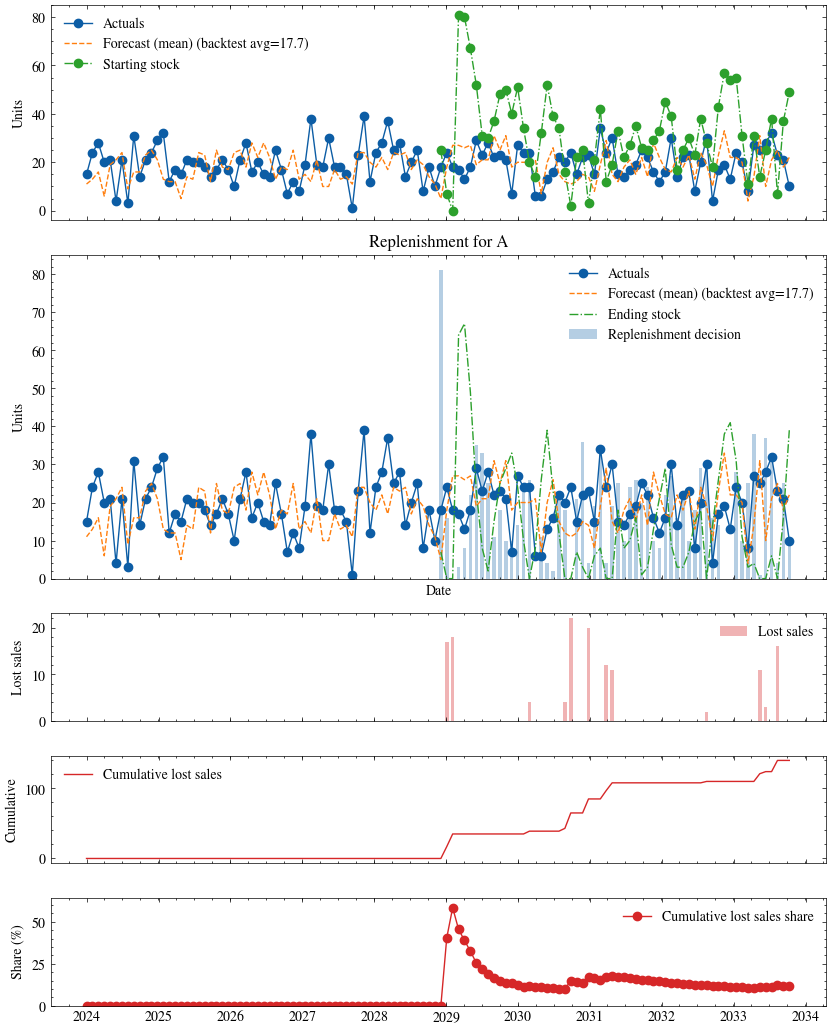

In [5]:
example_id = sigma_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, sigma_decisions_df, unique_id=example_id)


## 3) Optimize Sigma + Aggregation Window


In [6]:
candidate_windows

[3, 6, 9]

In [7]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.95,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="service_level",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="service_level",
)


In [8]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)
agg_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2028-12-05,115,18,16.666667,43.333333,27.101671,77.101671,0,25,...,7,115,0,0,0.28,3,3,3,3,None
1,A,2029-01-04,0,24,24.000000,48.000000,49.101671,121.101671,0,7,...,0,115,0,17,0.28,3,3,3,3,None
2,A,2029-02-03,0,18,26.666667,49.000000,57.101671,137.101671,0,0,...,0,115,0,18,0.28,3,3,3,3,None
3,A,2029-03-05,25,17,26.666667,47.000000,57.101671,137.101671,115,115,...,98,25,0,0,0.28,3,3,3,3,None
4,A,2029-04-04,0,13,24.000000,48.333333,49.101671,121.101671,0,98,...,85,25,0,0,0.28,3,3,3,3,None


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     1
18     0
19     0
20     0
21     0
22    13
23    15
24     0
25     0
26    14
27     0
28     7
29    30
30     0
31     0
32     0
33     0
34     0
35     1
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     1
54     0
55     4
56    32
57     0
58     0
59     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

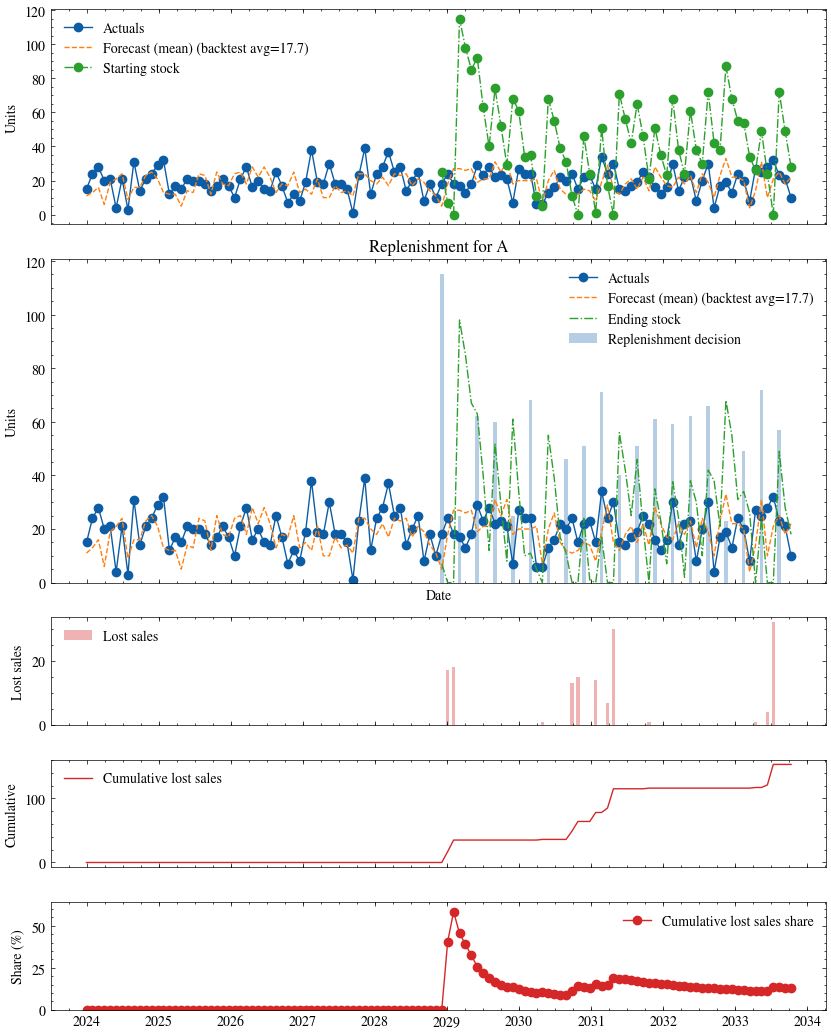

In [9]:
example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)


### Take a given service level and optimize aggregation windows

In [10]:
candidate_windows

[3, 6, 9]

In [11]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.99,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=[.90],
    service_level_mode="service_level",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="service_level",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="service_level",
)


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
Name: missed_sales, dtype: int64


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2028-12-05,188,18,16.666667,43.333333,100.348832,150.348832,0,25,...,7,188,0,0,0.9,3,3,3,3,None
1,A,2029-01-04,0,24,24.000000,48.000000,122.348832,194.348832,0,7,...,0,188,0,17,0.9,3,3,3,3,None
2,A,2029-02-03,0,18,26.666667,49.000000,130.348832,210.348832,0,0,...,0,188,0,18,0.9,3,3,3,3,None
3,A,2029-03-05,25,17,26.666667,47.000000,130.348832,210.348832,188,188,...,171,25,0,0,0.9,3,3,3,3,None
4,A,2029-04-04,0,13,24.000000,48.333333,122.348832,194.348832,0,171,...,158,25,0,0,0.9,3,3,3,3,None


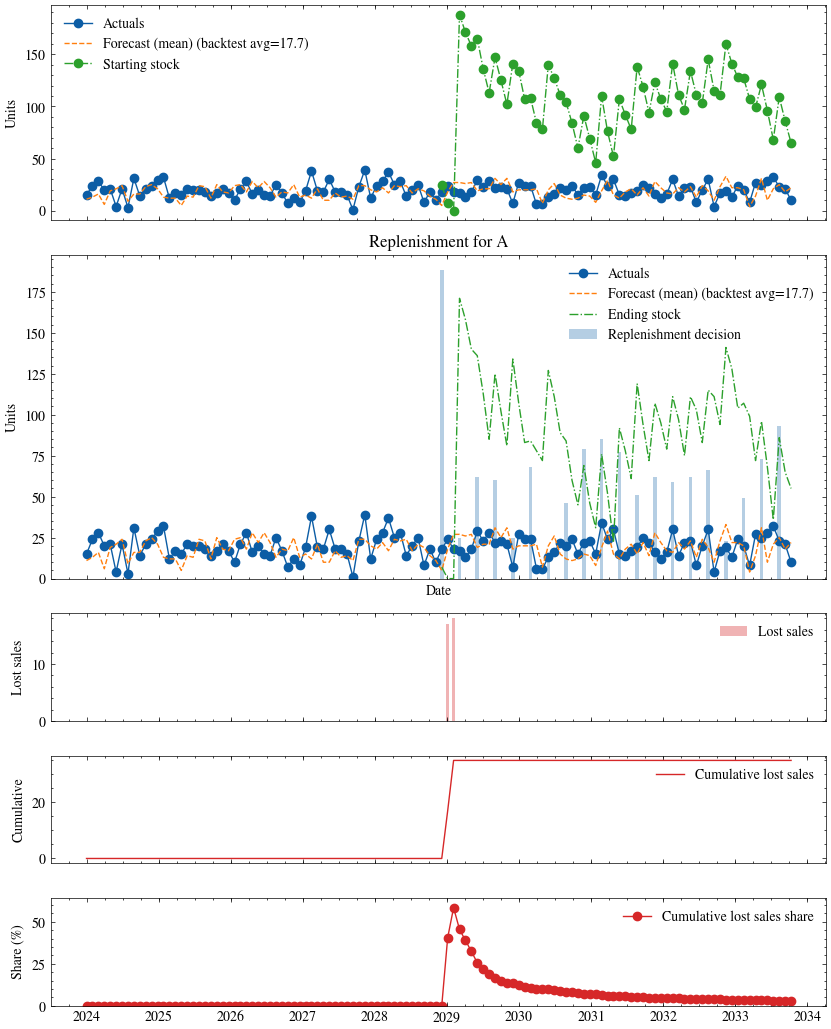

In [12]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)

example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)

agg_decisions_df.head()

## 4) Review period + forecast horizon (set/optimize)

- **review_period** = order cadence (every N periods).
- **forecast_horizon** = coverage window *excluding* lead time.
- Total protection horizon used in the policy is **lead_time + forecast_horizon**.

Note: the *review period* can already be optimized via `candidate_windows` in section 3.


In [36]:
# --- set review period + forecast horizon ---

backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    rmse_window=rmse_window,
)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)

optimized = optimize_service_level_factors(
    point_configs,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)
best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

eval_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=best_factors,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
eval_simulations = simulate_replenishment_for_articles(eval_configs)
review_horizon_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    eval_simulations,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
    sigma=best_factors,
    fixed_rmse=backtest_rmse,
    service_level_mode="service_level",
)


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     3
23    15
24     0
25     0
26    14
27     0
28     0
29    27
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56    27
57     0
58     0
59     0
Name: missed_sales, dtype: int64


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2028-12-05,125,18,16.666667,43.333333,37.998453,87.998453,0,25,...,7,125,0,0,0.38,3,3,3,3,None
1,A,2029-01-04,0,24,24.000000,48.000000,59.998453,131.998453,0,7,...,0,125,0,17,0.38,3,3,3,3,None
2,A,2029-02-03,0,18,26.666667,49.000000,67.998453,147.998453,0,0,...,0,125,0,18,0.38,3,3,3,3,None
3,A,2029-03-05,25,17,26.666667,47.000000,67.998453,147.998453,125,125,...,108,25,0,0,0.38,3,3,3,3,None
4,A,2029-04-04,0,13,24.000000,48.333333,59.998453,131.998453,0,108,...,95,25,0,0,0.38,3,3,3,3,None


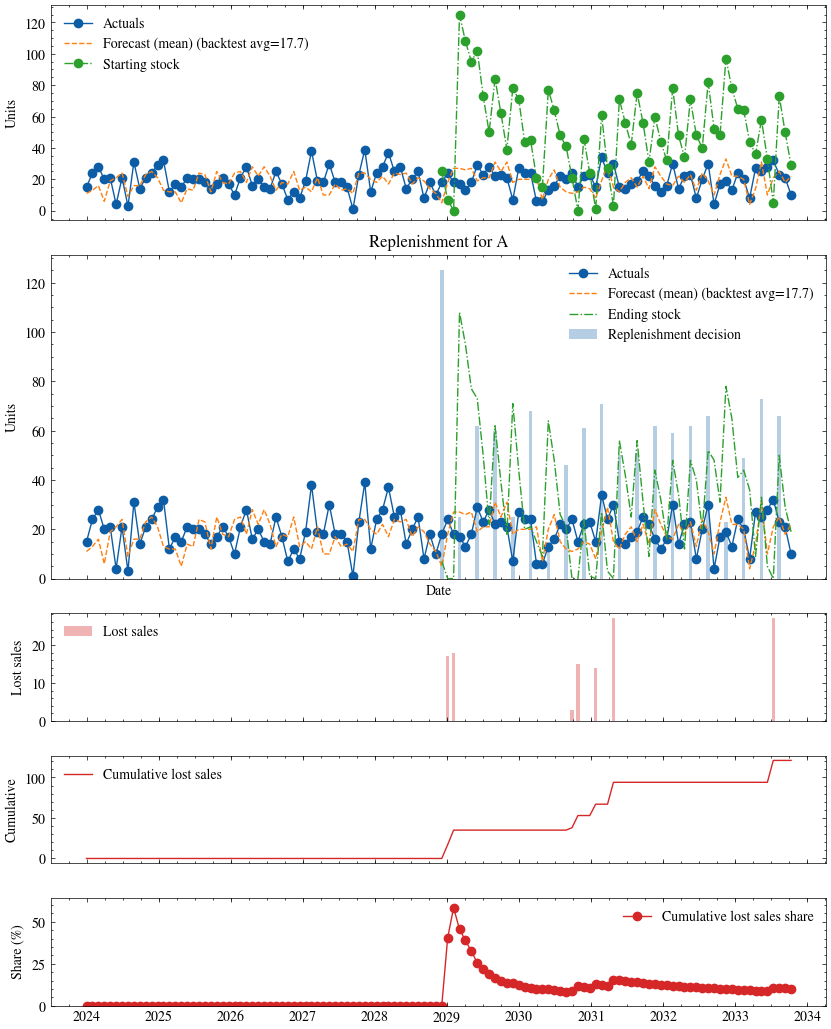

In [43]:
review_horizon_df = replenishment_decision_rows_to_dataframe(
    review_horizon_decisions
)

example_id = review_horizon_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, review_horizon_df, unique_id=example_id)
review_horizon_df.head()


In [38]:
# --- optional: brute-force optimize forecast_horizon (review_period fixed) ---
candidate_horizons = [1, 2, 3, 4, 5, 7, 10]
horizon_costs = {}
for horizon in candidate_horizons:
    point_configs = build_point_forecast_article_configs_from_standard_rows(
        backtest_rows,
        service_level_factor=candidate_service_levels[0],
        service_level_mode="service_level",
        fixed_rmse=backtest_rmse,
        review_period=review_period,
        forecast_horizon=horizon,
        rmse_window=rmse_window,
    )
    optimized = optimize_service_level_factors(
        point_configs,
        candidate_factors=candidate_service_levels,
        service_level_mode="service_level",
    )
    best_factors = {
        unique_id: result.service_level_factor
        for unique_id, result in optimized.items()
    }
    eval_configs = build_point_forecast_article_configs_from_standard_rows(
        evaluation_rows,
        service_level_factor=best_factors,
        service_level_mode="service_level",
        fixed_rmse=backtest_rmse,
        actuals_override=backtest_actuals,
        review_period=review_period,
        forecast_horizon=horizon,
        rmse_window=rmse_window,
    )
    eval_simulations = simulate_replenishment_for_articles(eval_configs)
    horizon_costs[horizon] = sum(
        sim.summary.total_cost for sim in eval_simulations.values()
    )

best_horizon = min(horizon_costs, key=horizon_costs.get)
horizon_costs, best_horizon


({1: 796392.0,
  2: 662933.0,
  3: 624005.0,
  4: 687275.0,
  5: 824043.0,
  7: 1198473.0,
  10: 1802811.0},
 3)

0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     3
23    15
24     0
25     0
26    14
27     0
28     0
29    27
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56    27
57     0
58     0
59     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

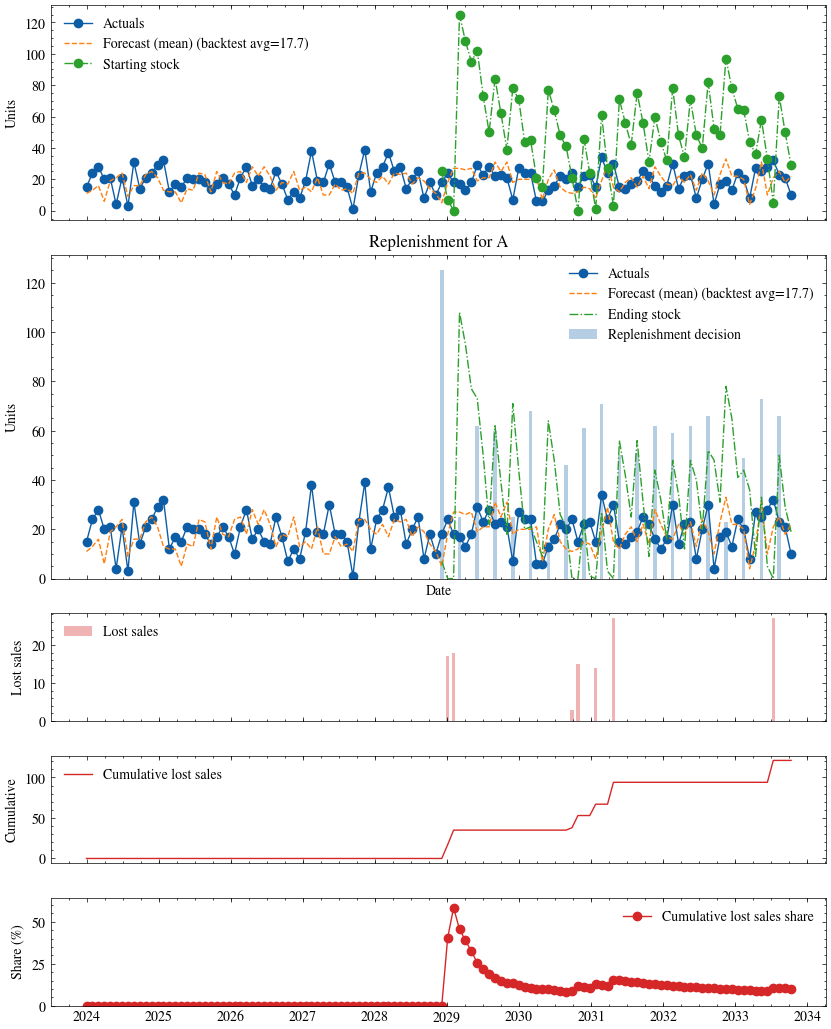

In [39]:
# Evaluate again with the best horizon
best_horizon

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
    review_period=review_period,
    forecast_horizon=best_horizon,
    rmse_window=rmse_window,
)
optimized = optimize_service_level_factors(
    point_configs,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)
best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

eval_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=best_factors,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
    review_period=review_period,
    forecast_horizon=best_horizon,
    rmse_window=rmse_window,
)
eval_simulations = simulate_replenishment_for_articles(eval_configs)
best_horizon_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    eval_simulations,
    review_period=review_period,
    forecast_horizon=best_horizon,
    rmse_window=rmse_window,
    sigma=best_factors,
    fixed_rmse=backtest_rmse,
    service_level_mode="service_level",
)
best_horizon_df = replenishment_decision_rows_to_dataframe(best_horizon_decisions)
example_id = best_horizon_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, best_horizon_df, unique_id=example_id)


In [40]:
agg_decisions_df[agg_decisions_df.ds > '2026-06-19']['missed_sales'].sum()

np.int64(7247)

In [41]:
agg_decisions_df[agg_decisions_df.ds > '2026-06-19']['demand'].sum()

np.int64(240519)

In [42]:
77 / 116312

0.0006620125180548869